4장에서는 One-Stage Detector 모델인 RetinaNet을 활용해 의료용 마스크 탐지 모델을 구축해보았습니다. 이번 장에서는 Two-Stage Detector인 Faster R-CNN으로 객체 탐지를 해보도록 하겠습니다.

5.1절부터 5.3절까지는 2장과 3장에서 확인한 내용을 바탕으로 데이터를 불러오고 훈련용, 시험용 데이터로 나눈 후 데이터셋 클래스를 정의하겠습니다. 5.4절에서는 torchvision API를 활용하여 사전 훈련된 모델을 불러오겠습니다. 5.5절에서는 전이 학습을 통해 모델 학습을 진행한 후 5.6절에서 예측값 산출 및 모델 성능을 확인해보겠습니다.

실험에 앞서 Google Colab에서는 랜덤 GPU를 할당하고 있기 때문에 메모리 부족현상이 일어날 수 있습니다.

먼저 GPU를 확인 후에 메모리가 충분할 경우 실험을 하시길 권장합니다. 런타임을 초기화할 경우 새로운 GPU를 할당받으실 수 있습니다.

In [5]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.') #There are 1 GPU(s) available.
    device = torch.device("cpu") #We will use the GPU: GeForce RTX 3090

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 3090


5.1 데이터 불러오기
모델링 실습을 위해 2.1절에 나온 코드를 활용하여 데이터를 불러오겠습니다. 가짜연구소 깃허브의 Tutorial-Book-Utils에 있는 PL_data_loader.py 파일로 FascMaskDetection 데이터셋을 다운받고 압축 파일을 푸는 순서입니다.

In [6]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.


Face Mask Detection.zip is done!


'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


5.2 데이터 분리

3.3절과 같이 데이터셋을 분리해보도록 하겠습니다. 아래 코드를 통해 임의로 170장을 추출하고 test폴더에 옮기는 작업을 수행합니다.

In [7]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))


853
853
683
683
170
170


또한 모델링에 필요한 패키지를 불러오겠습니다. 

torchvision은 이미지 처리를 하기 위해 사용되며 데이터셋에 관한 패키지와 모델에 관한 패키지가 내장되어 있습니다.

In [8]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

5.3 데이터셋 클래스 정의

이번에는 바운딩 박스를 위한 함수들을 2.3절과 마찬가지로 정의해줍니다.

In [10]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

또한 4.3절처럼 데이터셋 클래스와 데이터 로더를 정의해줍니다. 데이터셋은 torch.utils.data.DataLoader 함수를 통해 배치 사이즈는 4로 지정하여 불러오겠습니다.배치 사이즈는 개인의 메모리 크기에 따라 자유롭게 설정하면 됩니다.

In [11]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

5.4 모델 불러오기

torchvision.models.detection에서는 Faster R-CNN API(torchvision.models.detection.fasterrcnn_resnet50_fpn)를 제공하고 있어 쉽게 구현이 가능합니다. 이는 COCO 데이터셋을 ResNet50으로 pre-trained한 모델을 제공하고 있으며, pretrained=True/False로 설정할 수 있습니다.

이후 모델을 불러올 때는 num_classes에 원하는 클래스 개수를 설정하고 모델을 사용하면 됩니다. Faster R-CNN 사용 시 주의할 점은 background 클래스를 포함한 개수를 num_classes에 명시해주어야 합니다. 즉, 실제 데이터셋의 클래스 개수에 1개를 늘려 background 클래스를 추가해주어야 합니다.

In [12]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

5.5 전이 학습

Face Mask Detection에 전이 학습을 실시해 보겠습니다. Face Mask Detection 데이터셋은 3개의 클래스로 이루어져 있지만 background 클래스를 포함하여 num_classes를 4로 설정한 후 모델을 불러옵니다.

GPU를 사용할 수 있는 환경이라면 device로 지정하여 불러온 모델을 GPU에 보내줍니다.

In [13]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

위의 출력되는 결과를 통해 Fastser R-CNN이 어떤 layer들로 구성되어 있는지 알 수 있습니다. 
이 때, GPU 사용 가능 여부는 torch.cuda.is_available()를 통해 알 수 있습니다.

In [14]:
torch.cuda.is_available()

True

이제 모델이 만들어졌으니 학습을 해보겠습니다. 
학습 횟수(num_epochs)는 10으로 지정하고, SGD 방법을 통해 최적화 시켜보겠습니다. 
각 하이퍼 파라미터는 자유롭게 수정하여 사용할 수 있습니다.

In [15]:
num_epochs = 100
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

이제 학습을 시켜보겠습니다. 
위에서 생성한 data_loader에서 한 배치씩 순서대로 모델에 사용하며, 
이후 로스 계산을 통해 최적화를 수행합니다. 각 에폭마다 출력되는 로스를 통해서 학습이 진행되는것을 확인할 수 있습니다.

In [16]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 74.32024383544922, time : 76.14078044891357
epoch : 2, Loss : 49.04164505004883, time : 73.41376423835754
epoch : 3, Loss : 42.77726745605469, time : 73.36384153366089
epoch : 4, Loss : 36.694828033447266, time : 73.3812165260315
epoch : 5, Loss : 32.57734298706055, time : 73.36666107177734
epoch : 6, Loss : 31.723426818847656, time : 73.50261950492859
epoch : 7, Loss : 30.547969818115234, time : 73.52323079109192
epoch : 8, Loss : 27.32754135131836, time : 74.2885811328888
epoch : 9, Loss : 24.965803146362305, time : 74.49873518943787
epoch : 10, Loss : 23.808528900146484, time : 74.50984740257263


학습시킨 가중치를 저장하고 싶다면, torch.save를 이용하여 저장해두고 나중에 언제든지 불러와 사용할 수 있습니다.

In [17]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [18]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

5.6 예측
모델 학습이 끝났으면 잘 학습되었는지 예측 결과를 확인해보겠습니다. 예측결과에는 바운딩 박스의 좌표(boxes)와 클래스(labels), 점수(scores)가 포함됩니다. 점수(scores)에는 해당 클래스의 신뢰도 값이 저장되는데 threshold로 0.5 이상인 것만 추출하도록 함수make_prediction를 정의하겠습니다. 그리고 test_data_loader의 첫번째 배치에 대해서만 결과를 출력해보았습니다.

In [19]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [20]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[118.0304,   3.4067, 130.9483,  18.8293],
        [215.1177,  61.6655, 246.9527,  97.8304]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9732, 0.9531], device='cuda:0')}, {'boxes': tensor([[165.4909,  91.0340, 178.4897, 109.5815],
        [219.0657, 100.2698, 256.7408, 138.9283],
        [ 41.6211, 109.8922,  66.1105, 141.2195],
        [130.7228, 109.7507, 174.8339, 153.0677],
        [ 29.4388,  89.5216,  44.4456, 104.0397],
        [302.8991, 131.5594, 330.2928, 160.0032],
        [ 83.4109,  84.6611,  94.6206,  98.4752],
        [  3.7549, 104.8863,  20.9942, 127.8164],
        [258.5231,  90.8301, 267.8979, 102.0279]], device='cuda:0'), 'labels': tensor([1, 2, 1, 2, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9950, 0.9918, 0.9893, 0.9877, 0.9832, 0.9802, 0.9495, 0.9273, 0.9154],
       device='cuda:0')}]


예측된 결과를 이용하여 이미지 위에 바운딩 박스를 그려보도록 하겠습니다. 위에서 정의한 plot_image_from_output 함수로 그림을 출력합니다. Target이 실제 바운딩 박스 위치이며 Prediction이 모델의 예측 결과입니다. 모델이 실제 바운딩 박스의 위치를 잘 찾은 것을 확인할 수 있습니다.

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


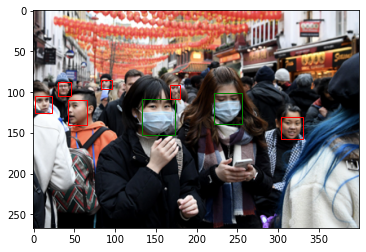

Prediction :  tensor([1, 2, 1, 2, 1, 1, 1, 1, 1], device='cuda:0')


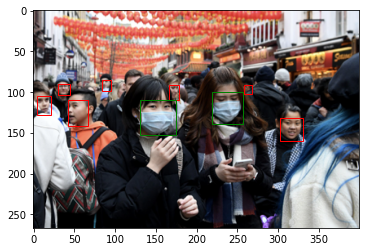

In [22]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

이번엔 전체 시험 데이터에 대해서 예측 결과를 평가해보도록 하겠습니다. 먼저 모든 시험 데이터에 대한 예측 결과와 실제 label을 각각 preds_adj_all, annot_all에 담아줍니다.

In [23]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:11<00:00,  7.16it/s]


그리고 Tutorial-Book-Utils 폴더 내에 있는 utils_ObjectDetection.py 파일을 통해서 mAP 값을 산출합니다. get_batch_statistics 함수를 통해 IoU(Intersection of Union) 조건을 만족하는 바운딩 박스간의 통곗값을 계산후 ap_per_class 함수를 통해 각 클래스에 대한 AP값을 계산해줍니다.

In [24]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

C:\Users\tykim\Desktop\Faster_RCNN\Tutorial-Book-Utils


In [25]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.7110464226546233
AP : tensor([0.8624, 0.9285, 0.3423], dtype=torch.float64)


AP값은 background 클래스를 제외한 실제 3개의 클래스에 대해서만 보여줍니다. 10번만 학습했음에도 불구하고 4장의 RetinaNet 결과보다 향상된 것을 확인할 수 있습니다. 특히나 1번 클래스인 마스크 착용 객체에 대해서는 0.9189 AP에 해당하는 정확도까지 보이고 2번 클래스인 마스크를 제대로 착용하고 있지 않는 객체에서도 0.3664 AP를 보이고 있습니다. RetinaNet이 FPN과 Focal loss로 one-stage method임에도 높은 성능을 보인다고 일반적으로 알려져 있습니다. 물론 하이퍼파라미터 튜닝을 통해 RetinaNet의 성능을 최적화 해도 되겠지만, 현재 실험 결과로 미뤄봤을 때 이 데이터셋에는 Faster-RCNN이 더 좋은 성능을 보이고 있습니다.

이상으로 의료용 마스크 탐지 튜토리얼을 마치도록 하겠습니다. 이번 튜토리얼을 통해서 데이터셋을 전처리하는 것부터 모델을 학습하고 예측하는 것까지 진행해보았습니다. 더 좋은 성능을 내기 위해서는 학습 횟수를 늘리거나 하이퍼파라미터 튜닝을 해보는 방법도 있습니다. 자신이 원하는 데이터에 객체 탐지 모델을 자유롭게 활용해보시기 바랍니다.